In [1]:
import cv2
import numpy as np
import glob
import os
import tensorflow as tf
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional

In [2]:
gen_sign = (glob.glob('Dataset_Signature_Final/Dataset/dataset1/real/*.*')+
            glob.glob('Dataset_Signature_Final/Dataset/dataset2/real/*.*')+
            glob.glob('Dataset_Signature_Final/Dataset/dataset3/real/*.*')+
            glob.glob('Dataset_Signature_Final/Dataset/dataset4/real/*.*'))
 
forg_sign = (glob.glob('Dataset_Signature_Final/Dataset/dataset1/forge/*.*')+
             glob.glob('Dataset_Signature_Final/Dataset/dataset2/forge/*.*')+
             glob.glob('Dataset_Signature_Final/Dataset/dataset3/forge/*.*')+
             glob.glob('Dataset_Signature_Final/Dataset/dataset4/forge/*.*'))

In [3]:
train_ratio = 0.8 
train_gen_sign = gen_sign[:int(len(gen_sign)* train_ratio)] 
test_gen_sign = gen_sign[int(len(gen_sign) *train_ratio):] 
train_forg_sign = forg_sign[:int(len(forg_sign)* train_ratio)] 
test_forg_sign = forg_sign[int(len(forg_sign) *train_ratio):]

train_image_paths =train_gen_sign + train_forg_sign 
test_image_paths = test_gen_sign + test_forg_sign

In [4]:
def preprocess_image(image_path, img_size=(256, 256), patch_size=(256, 256)):
    img= cv2.imread(image_path, cv2.IMREAD_GRAYSCALE) 
    # Read in grayscale 
    if img is None: 
        raise ValueError(f"Failed to load image: {image_path}") 
    img = cv2.resize(img, img_size)  
    return img_to_patches(img, patch_size)

In [5]:
def img_to_patches(img, patch_size=(256, 256)):
    patches = [] 
    for i in range(0, img.shape[0], patch_size[0]): 
        for j in range(0, img.shape[1], patch_size[1]):
            patch = img[i:i+patch_size[0], j:j+patch_size[1]].flatten() # Flatten eac 
            patches.append(patch) 
    return np.array(patches)

In [6]:
def process_images(image_paths, label):
    X_data = []
    y_data = []
    for image_path in image_paths:
        try:
            patches = preprocess_image(image_path)
            X_data.append(patches)
            y_data.append(label)
        except Exception as e:
            print(f"Error processing {image_path}: {e}")
    
    return np.array(X_data), np.array(y_data)  # Return after the loop finishes

In [7]:
x_train_real, y_train_real = process_images(train_gen_sign, label=0)
x_train_forg, y_train_forg = process_images(train_forg_sign, label=1) 

X_test_real, y_test_real = process_images(test_gen_sign, label=0) # for real 
X_test_forg, y_test_forg = process_images(test_forg_sign, label=1) 

X_train = np.concatenate([x_train_real, x_train_forg], axis=0) 
y_train = np.concatenate([y_train_real, y_train_forg], axis=0)

X_test = np.concatenate([X_test_real, X_test_forg], axis=0) 
y_test = np.concatenate([y_test_real, y_test_forg], axis=0)

#Shuffle the training data

indices = np.random.permutation(len(X_train))
X_train =X_train[indices]
y_train =y_train[indices]

#Shuffle the test data
test_indices = np.random.permutation(len(X_test)) 
x_test = X_test[test_indices] 
y_test = y_test[test_indices]

In [8]:
print("x_train shape:", X_train.shape)
print("y_train shape:", y_train.shape) 
print("X_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (576, 1, 65536)
y_train shape: (576,)
X_test shape: (144, 1, 65536)
y_test shape: (144,)


In [9]:
timesteps = X_train.shape[1] # number of patches per 
features = X_train.shape[2] #number of features pe

# Convert labels to categorical

y_train = to_categorical(y_train, num_classes=2)

y_test = to_categorical(y_test, num_classes=2)

In [10]:
model = Sequential([
    Bidirectional(LSTM(64, return_sequences=False), input_shape=(timesteps, features)), 
    Dense(64, activation= 'relu'), 
    Dense(2, activation='softmax') # 2 classes: genuine and forged
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 128)               33587712  
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 33,596,098
Trainable params: 33,596,098
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.save('bi_rnn_signature_verfication_model.h5')

In [13]:
history = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test))

Epoch 1/50
18/18 [==============================] - 12s 360ms/step - loss: 0.7255 - accuracy: 0.4811 - val_loss: 0.6989 - val_accuracy: 0.4861
Epoch 2/50
18/18 [==============================] - 4s 199ms/step - loss: 0.6947 - accuracy: 0.5208 - val_loss: 0.6994 - val_accuracy: 0.5000
Epoch 3/50
18/18 [==============================] - 3s 190ms/step - loss: 0.6940 - accuracy: 0.5168 - val_loss: 0.6977 - val_accuracy: 0.4861
Epoch 4/50
18/18 [==============================] - 3s 178ms/step - loss: 0.7009 - accuracy: 0.4332 - val_loss: 0.6959 - val_accuracy: 0.5069
Epoch 5/50
18/18 [==============================] - 3s 180ms/step - loss: 0.6949 - accuracy: 0.4635 - val_loss: 0.6943 - val_accuracy: 0.4792
Epoch 6/50
18/18 [==============================] - 3s 169ms/step - loss: 0.6922 - accuracy: 0.5122 - val_loss: 0.6936 - val_accuracy: 0.5069
Epoch 7/50
18/18 [==============================] - 3s 168ms/step - loss: 0.6917 - accuracy: 0.5029 - val_loss: 0.6927 - val_accuracy: 0.5139
Epoch

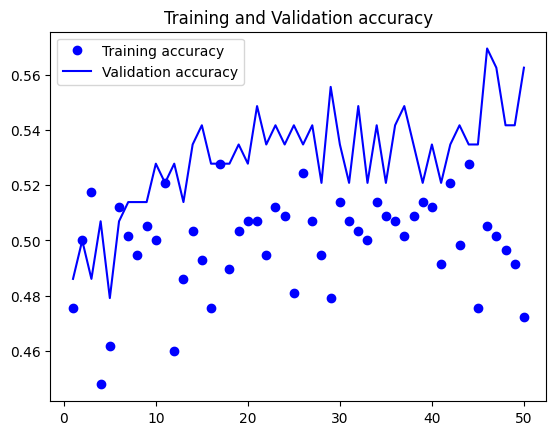

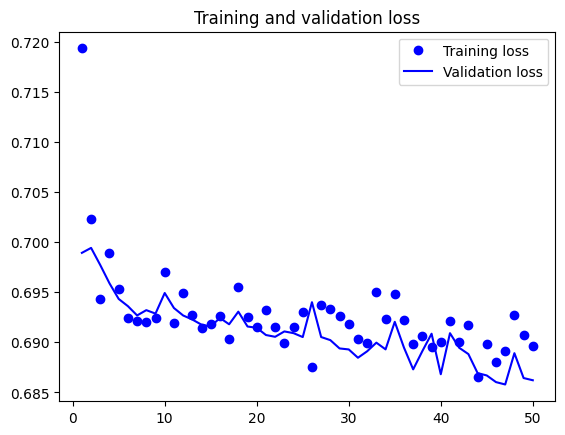

In [14]:
import matplotlib.pyplot as plt

#plot accuracy and loss

acc= history.history['accuracy'] 
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss= history.history['val_loss']

epochs= range(1,len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy') 
plt.title('Training and Validation accuracy')
plt.legend()
plt.show()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss') 
plt.title('Training and validation loss')

plt.legend()

plt.show()

In [15]:
#get the final loss and accuracy

final_loss, final_accuracy =model.evaluate(x_test, y_test)

#print the results in percentage form

print('Final loss: {:.2f}%'.format(final_loss * 100))

print('Final Accuracy: {:.2f}%'.format(final_accuracy* 100))

5/5 [==============================] - 0s 48ms/step - loss: 0.6988 - accuracy: 0.4931
Final loss: 69.88%
Final Accuracy: 49.31%


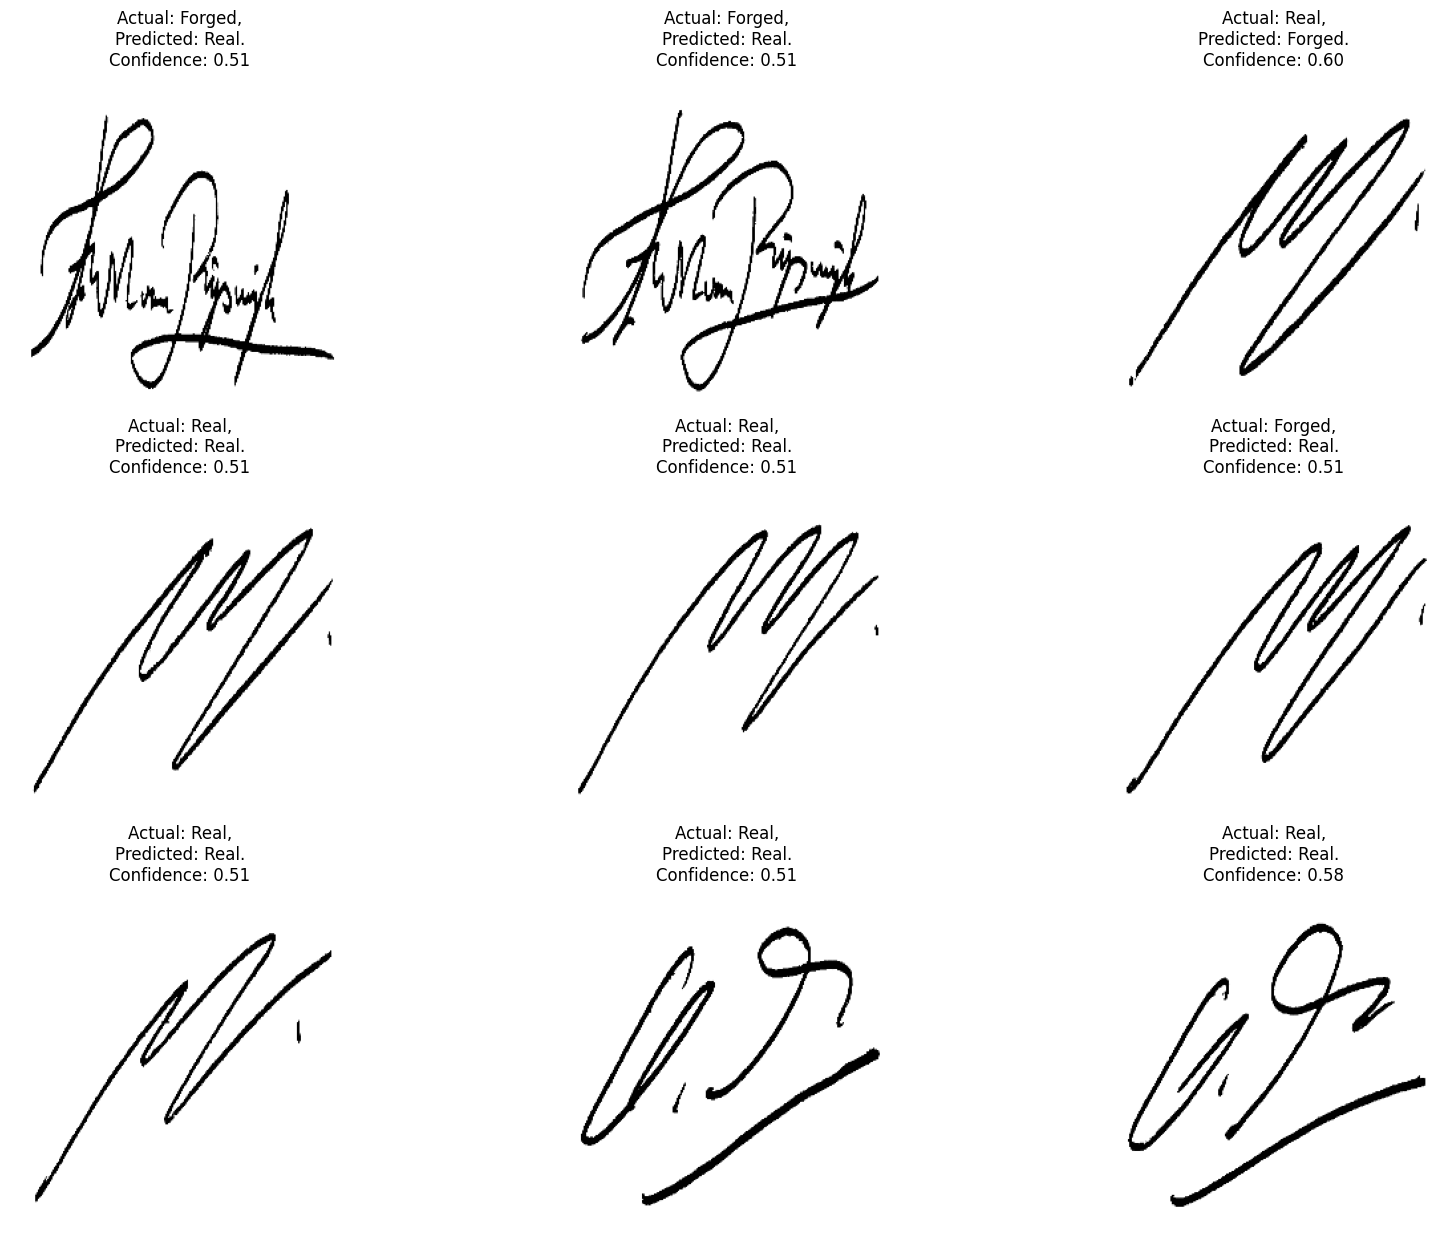

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 15))

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    image = X_test[i].reshape(256, 256)  # Adjusted shape to (128, 128)
    plt.imshow(image, cmap='gray') 
    predicted_class = np.argmax(model.predict(np.expand_dims(X_test[i], axis=0))) 
    confidence = np.max(model.predict(np.expand_dims(X_test[i], axis=0)))
    actual_class = np.argmax(y_test[i])
    class_names = ['Real', 'Forged']
    plt.title(f'Actual: {class_names[actual_class]},\nPredicted: {class_names[predicted_class]}.\nConfidence: {confidence:.2f}')
    ax.axis('off')

plt.show()
